In [1]:
import sys
sys.path.append("../")

In [2]:
from src.nnsrc.dense import NeuralNetwork

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
from matplotlib.pyplot import plot, legend

In [5]:
data = pd.read_csv('../src/data/regression/data.cube.train.100.csv')
X = data[["x"]].values
y = data["y"].values.reshape(-1,1)

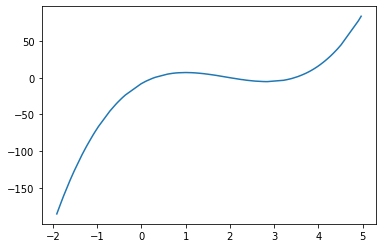

In [6]:
plot(*zip(*sorted(zip(data.x, data.y))))

In [7]:
X_train_scaler = MinMaxScaler((0,1))
Y_train_scaler = MinMaxScaler((0,1))
X_normed = X_train_scaler.fit_transform(X)
y_normed = Y_train_scaler.fit_transform(y)

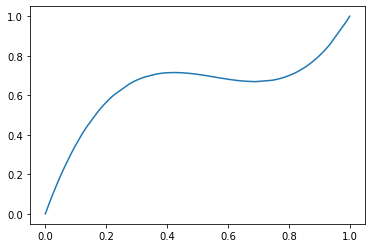

In [8]:
plot(*zip(*sorted(zip(X_normed, y_normed))))

In [9]:
#X_normed = X
#y_normed = y

In [10]:
copy_X_normed = X_normed.copy()

In [11]:
nn2 = NeuralNetwork(seed=1, n_layers=5,
                    n_neurons_per_layer=[1, 50,  50, 50, 1], act_funcs=['sigmoid', 'sigmoid','sigmoid', 'sigmoid', 'linear'],
                    bias=True, problem='regression')

for layer in nn2.layers:
    print(layer.name, layer.input_dim, layer.output_dim)

history = nn2.train(X_normed.T, y_normed, 1000, 0.3)

Dense_0 1 1
Dense_1 1 50
Dense_2 50 50
Dense_3 50 50
Dense_4 50 1


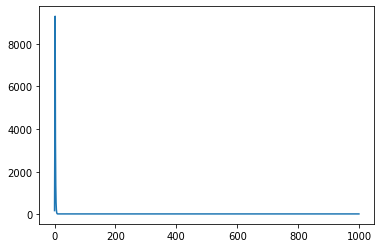

In [12]:
plot(history)

In [13]:
history[-1]

19.630762480366926

-9.000000000000005


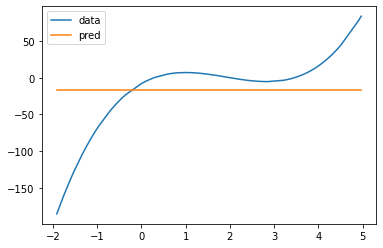

In [14]:
y_hat, cache = nn2.predict(X_normed.T)
#y_hat = MinMaxScaler().fit_transform(y_hat.reshape(-1,1))
data['y_predicted'] = Y_train_scaler.inverse_transform(y_hat.reshape(-1,1))
plot(*zip(*sorted(zip(data.x, data.y))), label='data')
plot(*zip(*sorted(zip(data.x, data.y_predicted))), label='pred')
legend()
print(1 - np.linalg.norm(y_hat - y_normed)/(np.linalg.norm(y_normed.mean()-y_normed)))

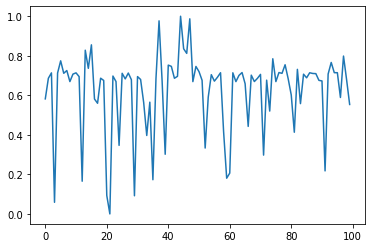

In [15]:
plot(y_normed)

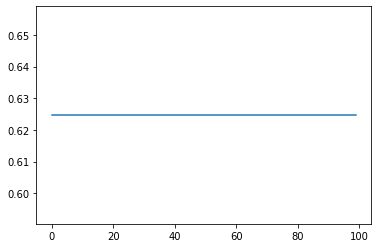

In [16]:
plot(y_hat[0])

In [17]:
## TEST ##

In [18]:
data = pd.read_csv('../src/data/regression/data.activation.test.100.csv')
X2 = data[["x"]].values
y2 = data['y'].values.reshape(-1,1)

#X2 = X_train_scaler.transform(X2)
y2 = Y_train_scaler.transform(y2)

y_hat2 = nn2.predict(X2.T)
y_hat2 = MinMaxScaler().fit_transform(y_hat2.reshape(-1,1))

print(1 - np.linalg.norm(y_hat2 - y2)/(np.linalg.norm(y2.mean()-y2)))

AttributeError: 'tuple' object has no attribute 'reshape'

In [ ]:
data['y_predicted'] = Y_train_scaler.inverse_transform(y_hat2)

In [ ]:
plot(*zip(*sorted(zip(data.x, data.y))), label='data')
plot(*zip(*sorted(zip(data.x, data.y_predicted))), label='pred')
legend()